In [1]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO


Not running on Colab


In [2]:
# from gekko import GEKKO


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time

In [3]:
# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
# from tqdm.keras import TqdmCallback

# from gekko import GEKKO


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
# from tqdm.keras import TqdmCallback

In [12]:
# Down sampling

sec = 25000
interval = 30

tcLab = pd.read_pickle('TCLab_MIMO_Data_003_25000.pkl') # Put the original name

downsampled_interval = interval # New interval (sec)



tcLab_resample = tcLab.iloc[::downsampled_interval, :]

# print(tcLab_resample) # Check the file

# tcLab_resample.to_pickle('Down_TCLab_MIMO_Data_001_1000_30s.pkl') # New name for down sample file

In [13]:
# File name
# Down_TCLab_MIMO_Data_001_1000_30s


data = tcLab_resample
# data = pd.DataFrame(np.array(data).T, columns=['u1', 'u2', 'y1', 'y2']).iloc[70:]

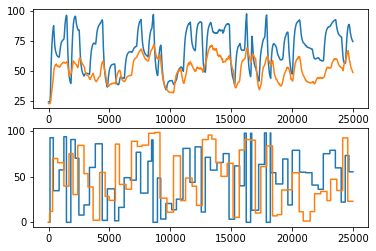

In [14]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(data[["T1", "T2"]]) # [300:1000] 원하는 구간 확인
plt.subplot(2,1,2)
plt.plot(data[["H1", "H2"]], drawstyle='steps') # [300:1000] 원하는 구간 확인
plt.show()

## 4. Train LSTM Network

In [15]:
window = 5 # 프레임 사이즈, 윈도우 사이즈, 몇초를 보느냐

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['H1', 'H2', 'T1', 'T2']].to_numpy())
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['T1', 'T2']].to_numpy())

In [16]:
Ys.shape, Xs.shape

((834, 2), (834, 4))

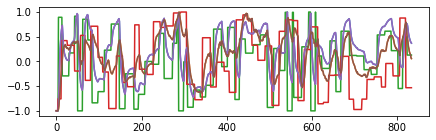

In [17]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [18]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param_MIMO.pkl', 'wb'))


In [19]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

417


/var/folders/cp/p82kw9zd4psdb4vl1wp3x09m0000gn/T/ipykernel_78394/2699983935.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set


In [20]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])

In [21]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [22]:
# Demension of training data set
np.shape(X_train), np.shape(Y_train)

((412, 5, 4), (412, 2))

In [23]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

Metal device set to: Apple M1 Pro


2022-05-12 15:12:58.994052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 15:12:58.994328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 250,\
                             callbacks=[es_lstm],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))


2022-05-12 15:13:02.132694: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 15:13:03.860915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:04.152551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:04.373530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:04.411281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:04.510234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:04.636170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Epoch 133: early stopping
Runtime: 11.05 s


In [27]:
#%% Save LSTM model file
model_lstm.save('MPC_MIMO_TCLab_onestep_LSTM.h5')

## 2. Transformer

In [26]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)


xl = tf.keras.layers.Flatten()(xl)
yl = tf.keras.layers.Dense(n_label, activation='linear')(xl)
model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))


2022-05-12 15:13:20.822327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:13:21.493018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 111: early stopping
Runtime: 50.08 s


In [28]:
#%% Save Transformer model file
model_trans.save('MPC_MIMO_TCLab_onestep_Trans.h5')

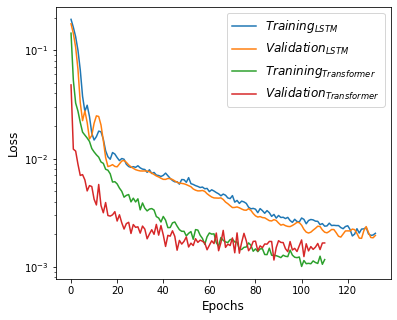

In [29]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

sec = str(sec)
interval = str(interval)


# plt.savefig('Loss_surrogate_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
plt.savefig('Loss_surrogate_SISO_FOPDT_' + sec + '_' + interval + 's.png')


## 5. Using measured values to predict next step

### LSTM

In [33]:
# # Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_onestep_LSTM.h5')
model_trans = load_model('MPC_MIMO_TCLab_onestep_Trans.h5')

2022-05-12 15:16:03.536986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:16:03.623641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:16:03.651515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 15:16:03.688843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


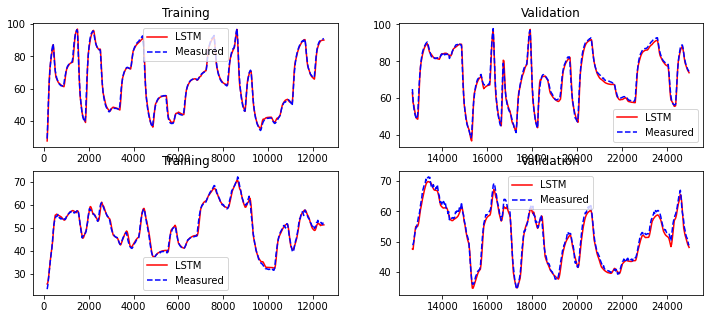

In [34]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value

plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Yu_train_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Yu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()



# plt.savefig('1.LSTM_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('1.LSTM_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.png')


### Transformer

2022-05-12 15:16:07.785394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


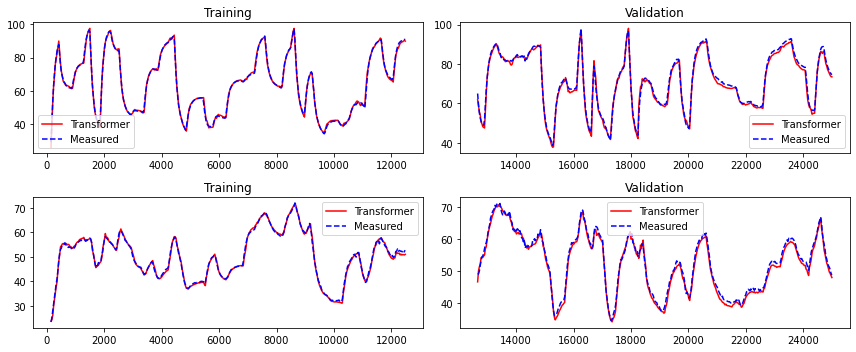

In [35]:
# Verify the fit of the model
Yp_train_trans = model_trans.predict(X_train)
Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value

plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Yu_train_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Yu_train_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Yu_val_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('1.Transformer_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('1.Transformer_Measured_SISO_FOPDT_' + sec + '_' + interval + 's.png')



## 6. Using predicted values to predict next step

### LSTM

In [36]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_lstm.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_train_lstm = Ytu[window:cut_index]
Ytu_val_lstm = Ytu[cut_index+window:]

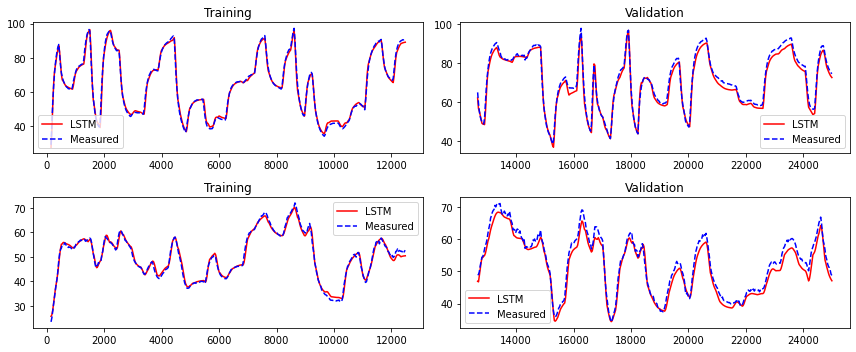

In [37]:
plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Ytu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Ytu_train_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Ytu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('2.LSTM_Values_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('2.LSTM_Values_SISO_FOPDT_' + sec + '_' + interval + 's.png')



### Transformer


In [38]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_trans.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_train_trans = Ytu[window:cut_index]
Ytu_val_trans = Ytu[cut_index+window:]

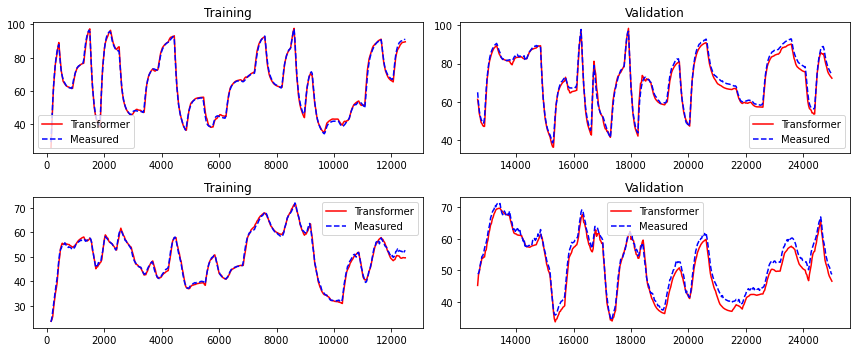

In [39]:
plt.figure(0, figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(data.index[window:cut_index],Ytu_train_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val_trans[:,0],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.subplot(2,2,3)
plt.plot(data.index[window:cut_index],Ytu_train_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[window:cut_index],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(2,2,4)
plt.plot(data.index[cut_index+window:],Ytu_val_trans[:,1],'r-',label='Transformer')
plt.plot(data.index[cut_index+window:],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()
plt.tight_layout()



# plt.savefig('2.Transformer_Values_SISO_FOPDT_' + sec + '_' + interval + 's.eps', format='eps')
# plt.savefig('2.Transformer_Values_SISO_FOPDT_' + sec + '_' + interval + 's.png')



# Model Validation Results for paper

## Case 1: Using small data 

In [105]:
# Load NN model parameters and MinMaxScaler
model_params = load(open(path + 'model_param_MIMO.pkl', 'rb'))
s1 = model_params['Xscale']
s2 = model_params['yscale']
window = model_params['window']

# Load validation data
tcLab = pd.read_pickle('(Val)TCLab_MIMO_Data_18500-22500.pkl')

# Downsample
interval = 30

downsampled_interval = interval # New interval (sec)
tcLab_resample = tcLab.iloc[::downsampled_interval, :]

# Scale
Xs = s1.transform(tcLab_resample[['H1', 'H2', 'T1', 'T2']].to_numpy())
Ys = s2.transform(tcLab_resample[['T1', 'T2']].to_numpy())

In [106]:
# Make snapshots
X_val = []
Y_val = []
for i in range(window,len(Xs)):
    X_val.append(Xs[i-window:i,:])
    Y_val.append(Ys[i])

In [107]:
# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [108]:
#Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_onestep_LSTM.h5')
model_trans = load_model('MPC_MIMO_TCLab_onestep_Trans.h5')

### LSTM-Onestep model evaluation

In [109]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_lstm.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_lstm = Ytu

Ym_val = s2.inverse_transform(Y_val)

2022-05-12 16:07:20.597084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 16:07:20.684077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 16:07:20.716110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 16:07:20.772100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Transformer-Onestep model evaluation

In [110]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_trans.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_trans = Ytu

2022-05-12 16:07:26.609347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


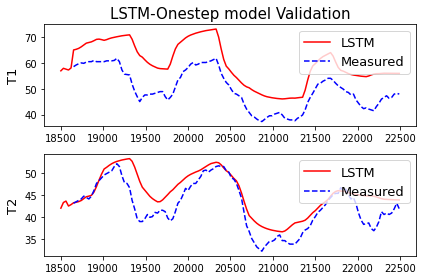

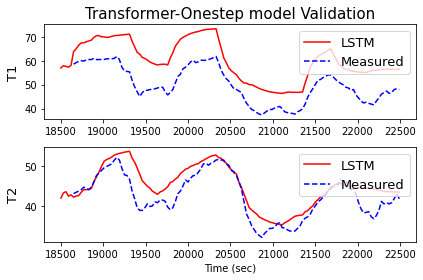

In [117]:
plt.figure(0, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index,Ytu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,0],'b--',label='Measured')
plt.title('LSTM-Onestep model Validation',fontsize=15)
plt.ylabel("T1", fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index,Ytu_val_lstm[:,1],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.tight_layout()

plt.figure(1, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index,Ytu_val_trans[:,0],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Transformer-Onestep model Validation',fontsize=15)
plt.ylabel("T1",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index,Ytu_val_trans[:,1],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:],Ym_val[:,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.xlabel("Time (sec)")
plt.legend(loc=1,fontsize=13)

plt.tight_layout()


plt.savefig('TCLab_validation_LSTM_Onestep.eps', format='eps')
plt.savefig('TCLab_validation_LSTM_Onestep.png')

## Case2 : Using sufficient data